In [1]:
%matplotlib inline 
import os
import numpy as np
import tensorflow as tf
import pymongo as pm
import gridfs
import cPickle
import scipy.signal as signal
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook, trange

from dldata.metrics.utils import compute_metric_base

Can't import separate mcc package
Can't import asgd.
Can't import scikits stuff


/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [37]:
# connect to database
dbname = 'final'
collname = 'yolo'
port = 24444

conn = pm.MongoClient(port = port)
coll = conn[dbname][collname + '.files']

# print out saved experiments in collection coll
all_exps = coll.distinct('exp_id')
all_exps = [i for i in all_exps if "step" in i]
exp_ids = {}
for i in all_exps:
    base, step = i.split('_')
    if base in exp_ids.keys():
        exp_ids[base] += [i]
    else:
        exp_ids[base] = [i]

In [28]:
exp_id = 'combined_fix'
# query the connection to get training steps
conn = pm.MongoClient(port=port)
coll = conn[dbname]['yolo.files']
steps = [i['step'] for i in coll.find({'exp_id': exp_id, 
                                       'train_results': {'$exists': True}}, projection=['step'])]
if exp_id == 'imagenet':
  #for imagenet-only model, we are only interested in its final training state
  steps = (steps[-1],)
else:
  #for other models, which are saved every 5k training steps, we want to evaluate every 30k steps 
  #by looking at every sixth record
  steps = steps[0::180] 

[150200, 185800, 221800, 257800, 293800, 329800, 365800, 401800]

In [3]:
from scipy.signal import convolve

def smooth_signal(lst, smooth=5):
    return convolve(lst, np.ones((smooth))/smooth, 'valid')

def get_losses(coll, exp_id):
    """
    Gets all loss entries from the database and concatenates them into a vector
    """
    q_train = {'exp_id' : exp_id, 'train_results' : {'$exists' : True}}
    return np.array([_r['loss'] 
                     for r in coll.find(q_train, projection = ['train_results']) 
                     for _r in r['train_results']])

In [58]:
def get_neural_validation_data(coll,exp_id):
    q_val = {'exp_id' : exp_id, 'validation_results' : {'$exists' : True}, 'validates': {'$exists' : True}}
    val_steps = coll.find(q_val, projection = ['validation_results', 'validates', 'exp_id'])
    results = [val_steps[i] for i in range(val_steps.count())]
    for res in results:
        res['step'] = coll.find({'_id': res['validates']})[0]['step']
    return results

validation_results = {}
for exp_id, steps in exp_ids.items():
    print(exp_id)
    validation_results[exp_id] = []
    for step in steps:
        vd = get_neural_validation_data(coll, exp_id=step)
        if len(vd) > 0:
            assert len(vd) == 1
            validation_results[exp_id] += [(int(step.split('_step')[1]), vd[0])]
            print('data keys:')
            print(vd[0]['validation_results'].keys())
        else:
            print('No Validation found')

imagenet
data keys:
[u'V6', u'VAll']


In [110]:
# example getting data
vd = validation_results['imagenet']
step = vd[0][0] # or vd[0][1]['step']
data_all = vd[0][1]['validation_results']['VAll']

In [97]:
from math import ceil
def plot_rdms(data, target_layers, step):
    """
    Displays the RDMs of all target layers.
    """
    ncols = 2
    nrows = ceil(len(target_layers)/float(ncols))
    plot_size = 4
    f = plt.figure(figsize=(plot_size*ncols, plot_size*nrows))
    for i, layer in enumerate(target_layers):
        rdm = data['rdm_%s' % layer]
        spearman_corrcoef = data['spearman_corrcoef_%s' % layer]
        ### YOUR CODE HERE
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(rdm)
        plt.title('%s: Spearman Coef: %.2f, Iter: %s' % (layer, spearman_corrcoef, step))
        ### END OF YOUR CODE
    plt.tight_layout()

def plot_categorization_results(data, target_layers, step):
    """
    Plots the confusion matrix and the average classification accuracy for each layer.
    """
    ncols = 2
    nrows = ceil(len(target_layers)/float(ncols))
    plot_size = 4
    f = plt.figure(figsize=(plot_size*ncols, plot_size*nrows))

    for i, layer in enumerate(target_layers):
        k = 'categorization_%s' % layer
        categorization_results = data[k]['result_summary']
        confusion = np.vstack([np.mean(performance, 1) for performance in categorization_results['cms']])
        acc = (np.mean(categorization_results['accbal'])-.5)*2 # why this?
        # plot
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(confusion)
        plt.xticks(range(8), categorization_results['labelset'], rotation=45)
        plt.yticks(range(8), categorization_results['labelset'])
        plt.colorbar(fraction=.045)
        plt.title('%s: Accuracy: %.2f' % (layer, acc))
        ### END OF YOUR CODE
    plt.tight_layout()

def plot_regression_results(data, target_layers, step):
    """
    Prints out the noise corrected multi rsquared loss for each layer.
    """
    for layer in target_layers:
        k = 'it_regression_%s' % layer
        regression_results = data[k]
        ### YOUR CODE HERE
        performance = 1-regression_results['noise_corrected_multi_rsquared_loss']
        print('layer: %s, step: %s, performance: %.2f' % (layer, step, performance))
        ### END OF YOUR CODE

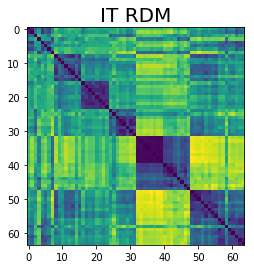

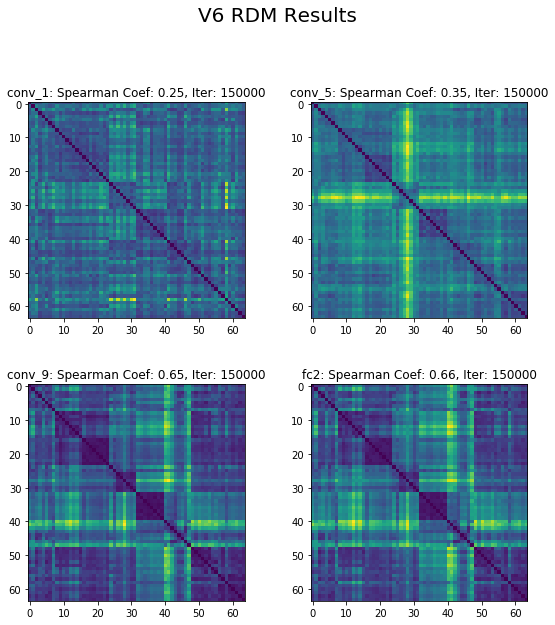

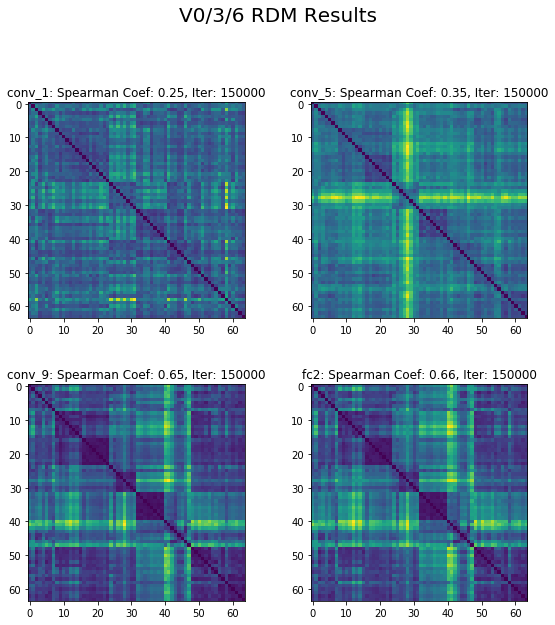

In [108]:
target_layers = ['conv_1', 'conv_5', 'conv_9', 'fc2']
idx = -1 ### YOUR idx HERE

for exp_id, vds in validation_results.items():
    vd = vds[idx]
    data_all = vd[1]['validation_results']['VAll']
    data_6 = vd[1]['validation_results']['V6']
    step = vd[0]
    
    plt.title('IT RDM', fontsize=20)
    plt.imshow(data_all['rdm_it'])

    plot_rdms(data_6, target_layers, step)
    plt.suptitle('V6 RDM Results', fontsize=20, y=1.1)

    plot_rdms(data_all, target_layers, step)
    plt.suptitle('V0/3/6 RDM Results', fontsize=20, y=1.1)

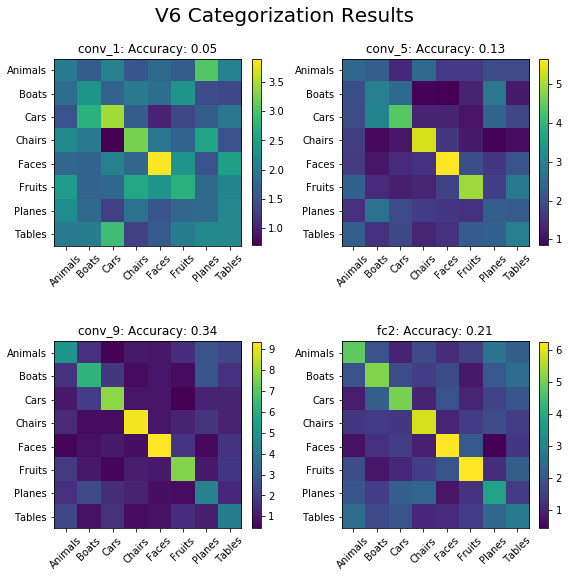

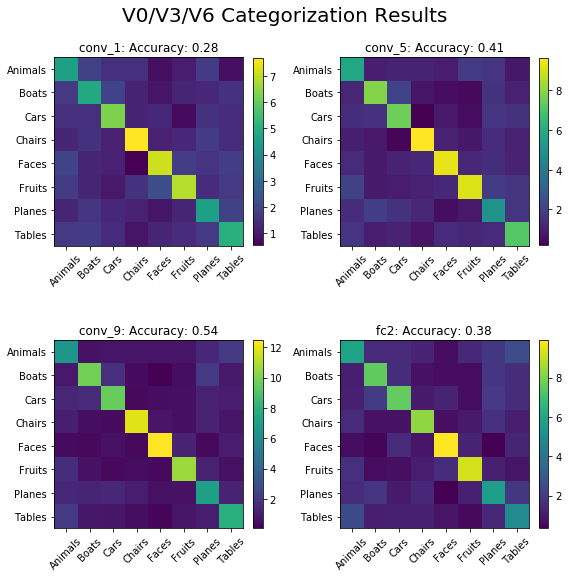

In [107]:
for exp_id, vds in validation_results.items():
    vd = vds[idx]
    data_all = vd[1]['validation_results']['VAll']
    data_6 = vd[1]['validation_results']['V6']
    step = vd[0]
        
    plot_categorization_results(data_6, target_layers, step,)
    plt.suptitle('V6 Categorization Results', fontsize=20, y=1.02)
    plot_categorization_results(data_all, target_layers, step)
    plt.suptitle('V0/V3/V6 Categorization Results', fontsize=20, y=1.02)

In [98]:
for exp_id, vds in validation_results.items():
    vd = vds[idx]
    data_all = vd[idx]['validation_results']['VAll']
    data_6 = vd[idx]['validation_results']['V6']
    step = vd[idx]['step']
        
    print('********** V 6 *********************')
    plot_regression_results(data_6, target_layers, step)
    plot_regression_results(data_all, target_layers, step)

********** V 6 *********************
layer: conv_1, step: 150000, performance: -0.00
layer: conv_5, step: 150000, performance: 0.31
layer: conv_9, step: 150000, performance: 0.40
layer: fc2, step: 150000, performance: 0.26
layer: conv_1, step: 150000, performance: 0.08
layer: conv_5, step: 150000, performance: 0.34
layer: conv_9, step: 150000, performance: 0.39
layer: fc2, step: 150000, performance: 0.27
